In [1]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, random_split
# Summary-like from Tensorflow
# from torchinfo import summary
# Import Numpy
import numpy as np
# Plot Import
import matplotlib.pyplot as plt
# For timer
import time
# Import OS
import os
from statistics import mean
# WFDB
import wfdb
# ==== LOCAL LIBS ====
import ecg_tools_lite as et
import evaluator as eva
import trainer as tr
import models as mod
# math
import math

In [5]:
all_e00 = np.load('all_none_fs1024_e00.npy').flatten()
all_e03 = np.load('all_none_fs1024_e03.npy').flatten()
all_e06 = np.load('all_none_fs1024_e06.npy').flatten()


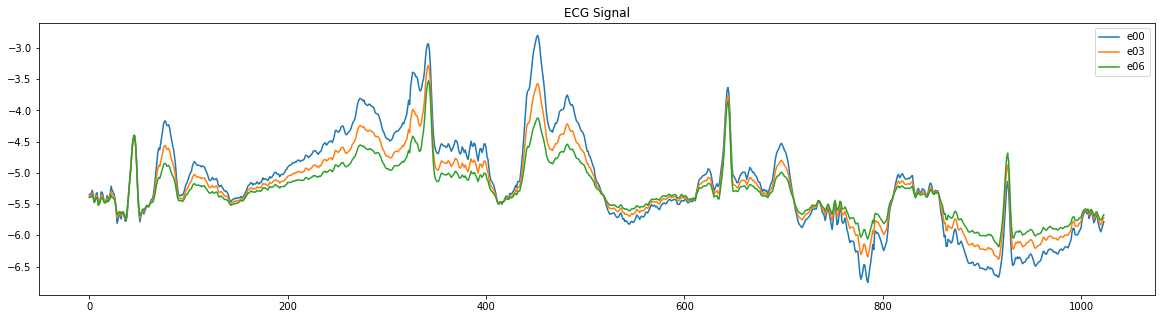

In [6]:
labels = ['e00', 'e03', 'e06']
et.ecg_plot( [all_e00, all_e03, all_e06], labels)